In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import yfinance as yf
import pandas as pd

import utils as lbl_utils
import ct_two_state as ct2
import ct_three_state as ct3
import fixed_time_horizon as fth
import oracle as oracle
import triple_barrier as tb

In [2]:
ticker_symbol = 'GC=F'
start_date = '2023-10-20'
end_date = '2023-10-21'
start_time = "10:50:00"
end_time = "12:00:00"

prices = yf.download(ticker_symbol, start_date, end_date, interval='1m')['Close'].between_time(start_time, end_time)
prices.index = prices.index.tz_localize(None)

print(prices.shape)
print(prices.head())

[*********************100%%**********************]  1 of 1 completed
(71,)
Datetime
2023-10-20 10:50:00    2000.500000
2023-10-20 10:51:00    2000.599976
2023-10-20 10:52:00    2001.800049
2023-10-20 10:53:00    2002.199951
2023-10-20 10:54:00    2003.099976
Name: Close, dtype: float64


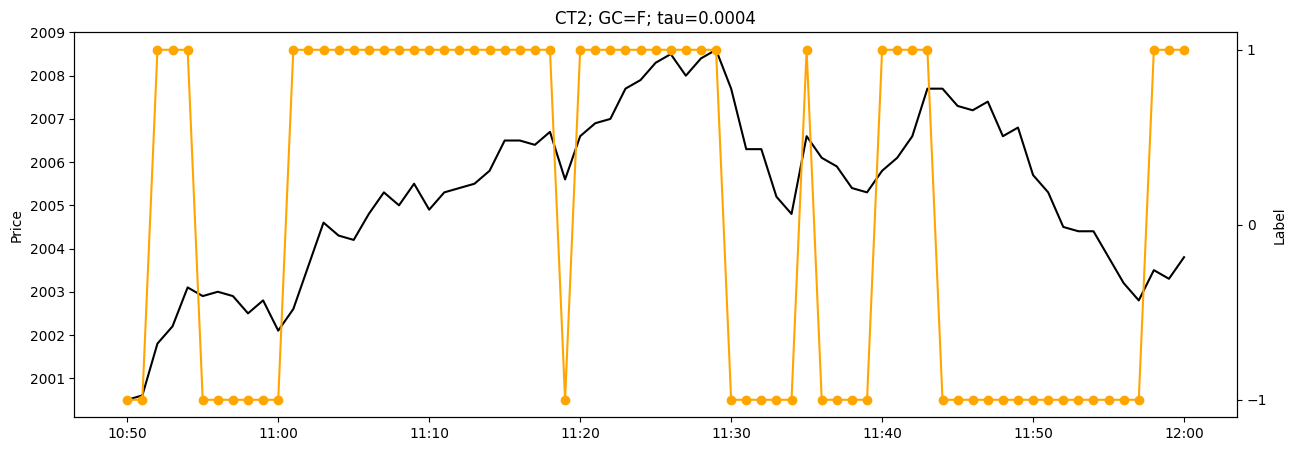

In [3]:
tau = 0.0004
labels = ct2.get_labels(prices, tau=tau)
lbl_utils.plot_labels('CT2; {}; tau={}'.format(ticker_symbol, tau), prices, labels)


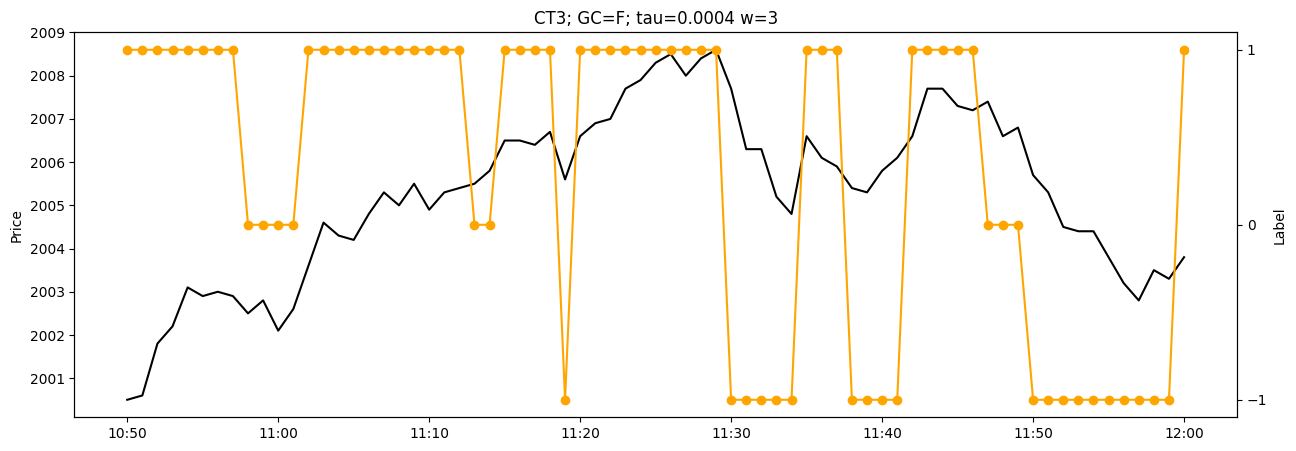

In [4]:
tau = 0.0004
window = 3
labels = ct3.get_labels(prices, tau=tau, w=window)
lbl_utils.plot_labels('CT3; {}; tau={} w={}'.format(ticker_symbol, tau, window), prices, labels)

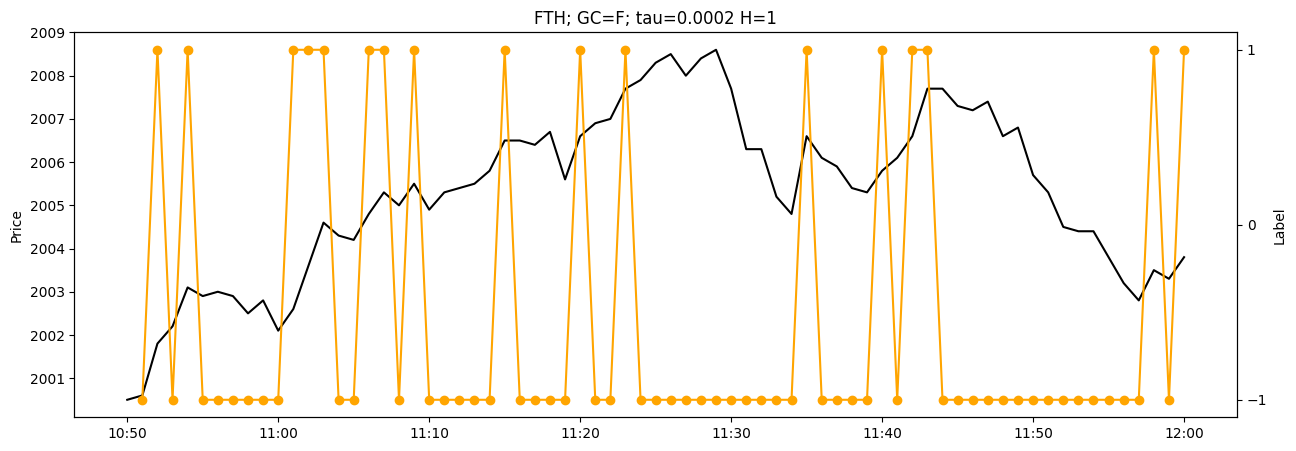

In [5]:
tau = 0.0002
H = 1
labels = fth.get_labels(prices, tau=tau, H=H)
lbl_utils.plot_labels('FTH; {}; tau={} H={}'.format(ticker_symbol, tau, H), prices, labels)

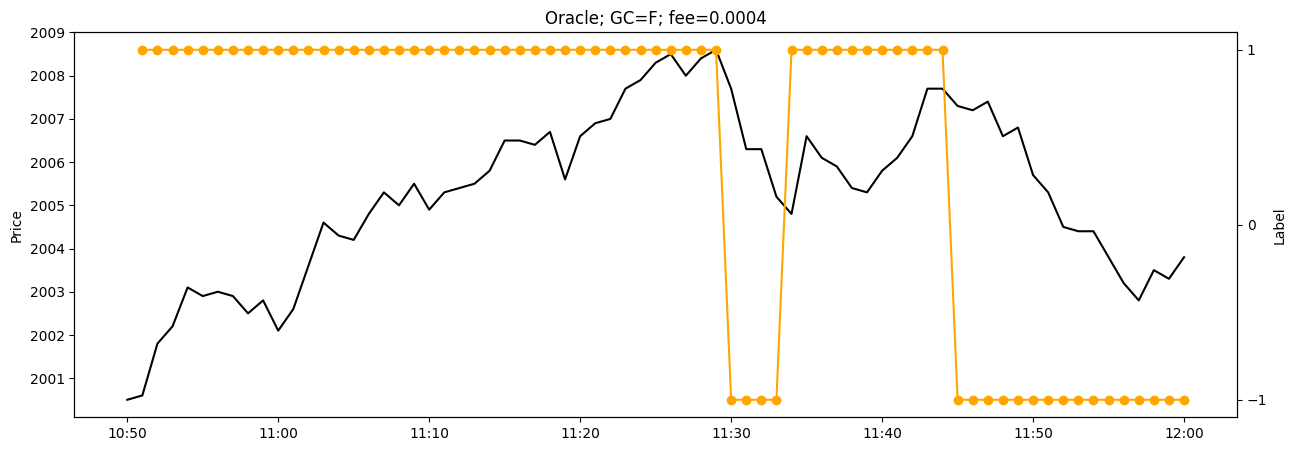

In [6]:
fee = 0.0004
labels = oracle.get_labels(prices, fee=fee)
labels[labels == 0] = -1
lbl_utils.plot_labels('Oracle; {}; fee={}'.format(ticker_symbol, fee), prices, labels)

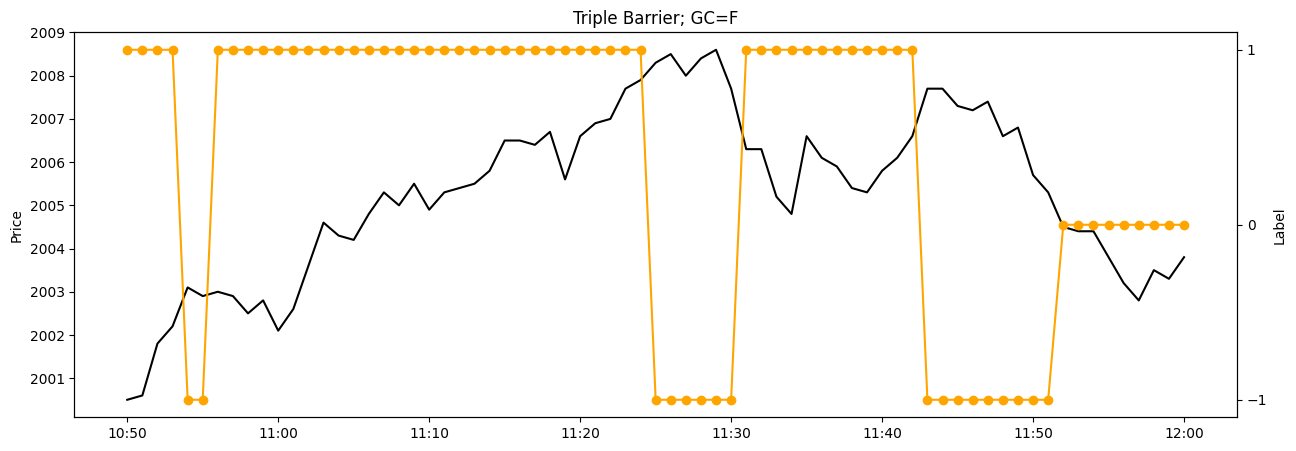

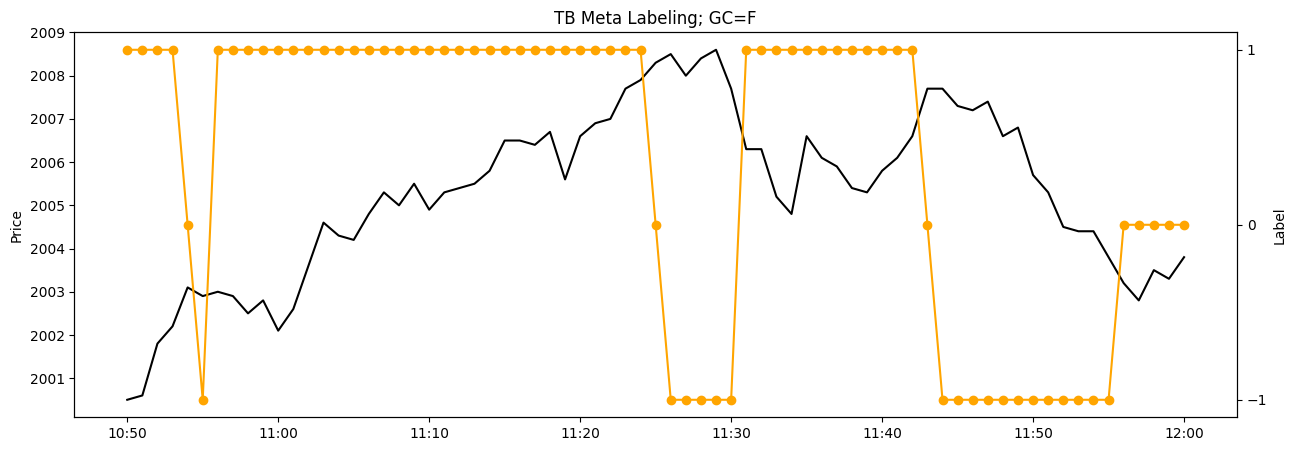

In [7]:
tEvents = prices.index
t1 = prices.index.searchsorted(tEvents + pd.Timedelta(hours=1))
t1 = pd.Series((prices.index[i] if i < prices.shape[0] else pd.NaT for i in t1), index=tEvents)

minuteVol = tb.getMinuteVol(prices, span=100)
minuteVol = minuteVol.reindex(tEvents).loc[tEvents].fillna(method='bfill')

labels = tb.get_labels(prices, tEvents, ptSl=[1, 2], volatility=minuteVol, minRet=0, t1=t1)
lbl_utils.plot_labels('Triple Barrier; {}'.format(ticker_symbol), prices, labels)

#-------------------------------------------
# Meta labeling
side = labels
side[side == 0] = -1
side = side.shift(1).fillna(method='bfill')

labels_2 = tb.get_labels(prices, tEvents, ptSl=[1, 2], volatility=minuteVol, minRet=0, t1=t1, side=side)
# iterate through labels_2 and if it has value 1 set ti to value from labels on same index, otherwise set to 0
labels_2 = pd.Series((labels[i] if labels_2[i] == 1 else 0 for i in labels_2.index), index=labels_2.index)
lbl_utils.plot_labels('TB Meta Labeling; {}'.format(ticker_symbol), prices, labels_2)